<a href="https://colab.research.google.com/github/Fernsrea/flow_matching/blob/main/MNIST_Discreet_FM_model_Inpainting_CurriculumDeterministicMask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd ..

/content


In [1]:
!git clone https://github.com/Fernsrea/flow_matching.git
%cd flow_matching

Cloning into 'flow_matching'...
remote: Enumerating objects: 496, done.
remote: Counting objects: 100% (276/276), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 496 (delta 192), reused 73 (delta 73), pack-reused 220 (from 2)
Receiving objects: 100% (496/496), 3.48 MiB | 6.71 MiB/s, done.
Resolving deltas: 100% (236/236), done.
/content/flow_matching


In [2]:
%cd examples/image

/content/flow_matching/examples/image


In [3]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962

In [ ]:
!pip install torchdiffeq

In [ ]:
!pip install flow_matching

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 2.7 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/masked_mnist/

masked_mnist_train.pt


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create target directory
import os
target_dir = '/content/drive/MyDrive/masked_mnist'
os.makedirs(target_dir, exist_ok=True)

# Import required libraries
import numpy as np
import torch
from torchvision.datasets import MNIST
from torchvision import transforms

# Parameters
mask_size = 10
image_size = 28

# Load MNIST
transform = transforms.ToTensor()
mnist = MNIST(root="./data", train=True, download=True, transform=transform)

# Create center mask
def create_center_mask(size, mask_size):
    mask = np.ones((size, size), dtype=np.uint8)
    start = (size - mask_size) // 2
    mask[start:start + mask_size, start:start + mask_size] = 0
    return mask

mask = create_center_mask(image_size, mask_size)
mask_tensor = torch.tensor(mask, dtype=torch.float32)  # (28, 28)

# Apply mask and store
images, masks, labels = [], [], []
for img, label in mnist:
    img = img.squeeze(0)  # (28, 28)
    masked = img * mask_tensor
    images.append(masked.unsqueeze(0))        # (1, 28, 28)
    masks.append(mask_tensor.unsqueeze(0))    # (1, 28, 28)
    labels.append(label)

# Stack and save
data = {
    'images': torch.stack(images),   # (N, 1, 28, 28)
    'masks': torch.stack(masks),     # (N, 1, 28, 28)
    'labels': torch.tensor(labels)   # (N,)
}
torch.save(data, os.path.join(target_dir, 'masked_mnist_train.pt'))
print("masked_mnist_train.pt saved to Google Drive with correct shape.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
masked_mnist_train.pt saved to Google Drive with correct shape.


In [5]:
import torch
import os
import shutil

# Define target directory for local copies
target_dir = '/content/flow_matching/examples/image/data/image_generation'
os.makedirs(target_dir, exist_ok=True)

# Define all dataset filenames
mask_sizes = [6, 10, 14]
datasets = {}

for size in mask_sizes:
    filename = f'masked_mnist_train_{size}.pt'
    drive_path = f'/content/drive/MyDrive/masked_mnist/{filename}'
    local_path = os.path.join(target_dir, filename)

    # Copy from Google Drive to local target directory
    shutil.copy(drive_path, local_path)

    # Load the .pt file and store contents in a dictionary
    data = torch.load(local_path)
    datasets[size] = {
        'images': data['images'],   # shape: (N, 1, 28, 28)
        'masks': data['masks'],     # shape: (N, 1, 28, 28)
        'labels': data['labels'],   # shape: (N,)
    }

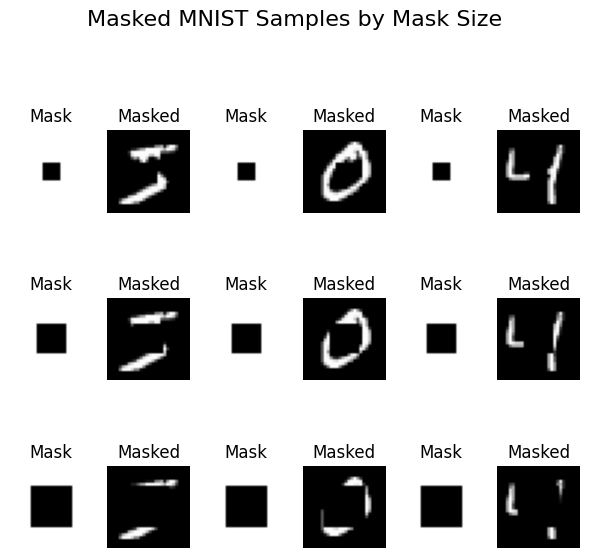

In [9]:
import matplotlib.pyplot as plt

def show_samples(datasets, samples_per_size=3):
    mask_sizes = sorted(datasets.keys())

    fig, axs = plt.subplots(len(mask_sizes), samples_per_size * 2, figsize=(samples_per_size * 2, len(mask_sizes) * 2))
    fig.suptitle("Masked MNIST Samples by Mask Size", fontsize=16, y=1.02)

    for row, size in enumerate(mask_sizes):
        images = datasets[size]['images']
        masks = datasets[size]['masks']

        for col in range(samples_per_size):
            idx = col  # or random index if preferred

            mask = masks[idx][0].numpy()
            masked = images[idx][0].numpy()

            axs[row, col * 2 + 0].imshow(mask, cmap='gray')
            axs[row, col * 2 + 0].set_title("Mask")
            axs[row, col * 2 + 0].axis('off')

            axs[row, col * 2 + 1].imshow(masked, cmap='gray')
            axs[row, col * 2 + 1].set_title("Masked")
            axs[row, col * 2 + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Call the visualization function
show_samples(datasets)

In [10]:
!python train.py \
    --dataset=mnist \
    --batch_size=32 \
    --accum_iter=1 \
    --eval_frequency=5 \
    --save_fid_samples \
    --num_workers=2 \
    --epochs=500 \
    --use_ema \
    --fid_samples=1000 \
    --discrete_flow_matching \
    --cfg_scale=0.0 \
    --data_path="./data/image_generation" \
    --output_dir='/content/drive/MyDrive/flow_matching_checkpoints_curr_29M' \
    --compute_fid \
    --test_run

Not using distributed mode
2025-05-29 16:18:07 INFO     job dir: /content/flow_matching/examples/image
2025-05-29 16:18:07 INFO     Namespace(batch_size=32,
epochs=500,
accum_iter=1,
lr=0.0001,
optimizer_betas=[0.9,
0.95],
decay_lr=False,
class_drop_prob=0.2,
skewed_timesteps=False,
edm_schedule=False,
use_ema=True,
dataset='mnist',
data_path='./data/image_generation',
output_dir='/content/drive/MyDrive/flow_matching_checkpoints_curr_29M',
ode_method='midpoint',
ode_options={'step_size': 0.01},
sym=0.0,
temp=1.0,
sym_func=False,
sampling_dtype='float32',
cfg_scale=0.0,
fid_samples=1000,
device='cuda',
seed=0,
resume='',
start_epoch=0,
eval_only=False,
eval_frequency=5,
compute_fid=True,
save_fid_samples=True,
num_workers=2,
pin_mem=True,
world_size=1,
local_rank=-1,
dist_on_itp=False,
dist_url='env://',
test_run=True,
discrete_flow_matching=True,
discrete_fm_steps=1024,
distributed=False)
2025-05-29 16:18:07 INFO     Saving args to /content/drive/MyDrive/flow_matching_checkpoints_curr_

In [ ]:
!python train.py \
    --dataset=mnist \
    --batch_size=32 \
    --accum_iter=1 \
    --eval_frequency=5 \
    --save_fid_samples \
    --num_workers=2 \
    --epochs=500 \
    --use_ema \
    --fid_samples=1000 \
    --discrete_flow_matching \
    --cfg_scale=0.0 \
    --data_path="./data/image_generation" \
    --output_dir='/content/drive/MyDrive/flow_matching_checkpoints_curr_29M' \
    --compute_fid --resume='/content/drive/MyDrive/flow_matching_checkpoints_curr_29M/checkpoint.pth'

Not using distributed mode
2025-05-28 22:56:07 INFO     job dir: /content/flow_matching/examples/image
2025-05-28 22:56:07 INFO     Namespace(batch_size=32,
epochs=500,
accum_iter=1,
lr=0.0001,
optimizer_betas=[0.9,
0.95],
decay_lr=False,
class_drop_prob=0.2,
skewed_timesteps=False,
edm_schedule=False,
use_ema=True,
dataset='mnist',
data_path='./data/image_generation',
output_dir='/content/drive/MyDrive/flow_matching_checkpoints_29M',
ode_method='midpoint',
ode_options={'step_size': 0.01},
sym=0.0,
temp=1.0,
sym_func=False,
sampling_dtype='float32',
cfg_scale=0.0,
fid_samples=1000,
device='cuda',
seed=0,
resume='/content/drive/MyDrive/flow_matching_checkpoints_29M/checkpoint.pth',
start_epoch=0,
eval_only=False,
eval_frequency=5,
compute_fid=True,
save_fid_samples=True,
num_workers=2,
pin_mem=True,
world_size=1,
local_rank=-1,
dist_on_itp=False,
dist_url='env://',
test_run=False,
discrete_flow_matching=True,
discrete_fm_steps=1024,
distributed=False)
2025-05-28 22:56:07 INFO     Saving